In [ ]:
from PIL import Image
import os
import numpy as np
import tensorflow as tf
from keras import ops
from keras.layers import StringLookup
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

2025-02-13 18:05:23.015875: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-13 18:05:23.159311: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739441123.215725   17296 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739441123.231997   17296 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-13 18:05:23.367851: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [ ]:
dataPath = "/home/b1az3/code/ml/trainingData/" #FILEPATH


--- words.txt ---------------------------------------------------------------#

 iam database word information

 format: a01-000u-00-00 ok 154 1 408 768 27 51 AT A

     a01-000u-00-00  -> word id for line 00 in form a01-000u
     ok              -> result of word segmentation
                            ok: word was correctly
                            er: segmentation of word can be bad

     154             -> graylevel to binarize the line containing this word
     1               -> number of components for this word NOTE: dont think this exists idk why
     408 768 27 51   -> bounding box around this word in x,y,w,h format
     AT              -> the grammatical tag for this word, see the
                        file tagset.txt for an explanation
     A               -> the transcription for this word


In [ ]:
text = open(dataPath + "ascii/words.txt","r").read().splitlines()
text = text[18:] #first 18 lines is metadata

images = []
for data in text:
    parts = data.split(" ")
    word = parts[-1]
    tmp = parts[0].split("-")
    path = dataPath + "final_aug_words/" + tmp[0]+"/"+tmp[0]+"-"+tmp[1]+"/"+parts[0]+"/"
    inDir = os.listdir(path)
    for f in inDir:
        images.append([os.path.join(path+f), word]) #last 2 are width and height

    

In [ ]:
images = np.array(images)

In [ ]:
np.random.shuffle(images)


In [ ]:
dimensionToResize = (224,224) #[0] is height, [1] is width
max_len = 21 #maximum length of word im guessing?
characters = [chr(i) for i in range (32,127)] #all characters that can be used?
batch_size = 64
padding_token = 0 #padding for labels because not all words have same len
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:

char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)

num_to_char = StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)


def process_images_and_labels(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    image = ops.cast(image, tf.float32) / 255.0 #change it to float32 0-1 instead of int 0-255
    label = vectorize_label(label)
    return {"image": image, "label": label}

def vectorize_label(label):
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    length = ops.shape(label)[0]
    pad_amount = max_len - length
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
    return label

def preprocess(img_paths, labels): #imgs contains [[path, label]*n]
    dataset = tf.data.Dataset.from_tensor_slices((img_paths, labels)).map(
        process_images_and_labels, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)

In [ ]:
images[0:2,0]
img_paths = images[:,0]
img_words = images[:,1]
print(img_paths[0])

/home/b1az3/code/ml/trainingData/final_aug_words/j04/j04-065/j04-065-05-07/image_0_2713.jpeg


In [ ]:
trainRatio, valRatio, testRatio = 0.85, 0.10, 0.05
trainNum = int(len(images)*trainRatio)
valNum = int(len(images)*valRatio)
testNum = len(images) - trainNum - valNum
trainDataset = preprocess(img_paths[:trainNum],img_words[:trainNum])
valDataset = preprocess(img_paths[trainNum:trainNum+valNum],img_words[trainNum:trainNum+valNum])
testDataset = preprocess(img_paths[trainNum+valNum:],img_words[trainNum+valNum:])


2025-02-13 18:21:36.948096: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-02-13 18:21:37.047418: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


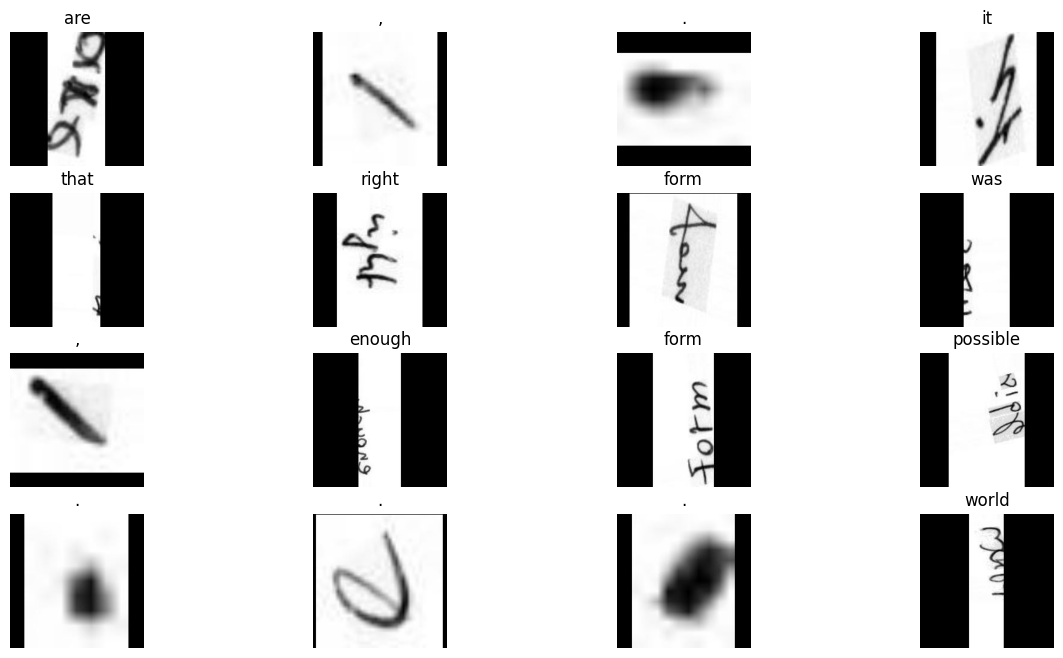

In [ ]:
for data in trainDataset.take(1):
    images, labels = data["image"], data["label"]

    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    for i in range(16):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = ops.transpose(img, (1, 0, 2))
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Gather indices where label!= padding_token.
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")

        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")


plt.show()

In [ ]:
trainRatio = 0.85
valRatio = 0.10
testRatio = 0.05
trainSize = int(trainRatio*len(images))
valSize = int(valRatio*len(images))
trainDataset = preprocess(images[:trainSize])
valDataset = preprocess(images[trainSize:trainSize+valSize])
testDataset = preprocess(images[trainSize+valSize:])

finally: model

In [ ]:
model = Sequential()
vgg = VGG16(include_top = False, pooling = "avg")

In [ ]:
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)